## **Libraries**

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, SGD
from tensorflow.keras import initializers
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import sys

In [ ]:
from google.colab import files
uploaded = files.upload()
%ls

Saving Round 5 Unbiased Scores.csv to Round 5 Unbiased Scores.csv
'Round 5 Unbiased Scores.csv'   sample_data/


In [ ]:
def load_knn_data():
  # X_train = np.genfromtxt('train.csv', delimiter=',')
  X_train = np.genfromtxt('Round 5 Unbiased Scores.csv', delimiter=',',skip_header=True)
  X_train = X_train[:,0:4]
  # fit scaler on data
  scaler = MinMaxScaler()
  scaler.fit(X_train)
  # apply transform
  X_train = scaler.transform(X_train)
  # opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
  # print(normalized)
  # inverse = scaler.inverse_transform(normalized)
  print(X_train.shape)
  return X_train, scaler



In [ ]:
a,b = load_knn_data()
print(b)

(3868, 4)
MinMaxScaler(copy=True, feature_range=(0, 1))


In [ ]:
class WGAN():
    def __init__(self):
      ################### img to data
        self.data_rows = 1
        self.data_cols = 4
        # self.channels = 1
        self.data_shape = (self.data_cols)
        ############################################################
        self.latent_dim = 4



        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.1
        optimizer = RMSprop(lr=0.0000005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        data = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(data)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])
        self.DLOS = np.array([])
        self.GLOS = np.array([])
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        model.add(Dense(50 , activation="relu", input_dim=self.latent_dim,kernel_initializer=initializer))
        model.add(Dense(30 , activation="relu"))
        model.add(Dense(15 , activation="relu"))
        model.add(Dense(4 , activation="sigmoid"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        data = model(noise)

        return Model(noise, data)
    def build_critic(self):

        model = Sequential()

        initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        model.add(Dense(50 , activation="relu",input_dim=4,kernel_initializer=initializer))
        model.add(Dense(25 , activation="relu"))
        model.add(Dense(8 , activation="relu"))
        model.add(Dense(1))
        model.summary()
        

        data = Input(shape=self.data_shape)
        validity = model(data)
        

        return Model(data, validity)
    # validity= build_critic(data)  
    # print(validity)
#################################################sample interval50 to 2
########################################################batch size 128 to 2
    def train(self, epochs, batch_size, sample_interval):

        # Load the dataset
        #####################################################
        # (X_train, _), (_, _) = mnist.load_data()
        X_train,_ = load_knn_data() 

        # Rescale -1 to 1
        ##################################################
        # X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        # X_train = np.expand_dims(X_train, axis=3)
        

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))
        # print(valid)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                data = X_train[idx]
                # print(data)
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_data = self.generator.predict(noise)
                # print(gen_data.shape)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(data, valid)
                # print(d_loss_real)
                d_loss_fake = self.critic.train_on_batch(gen_data, fake)
                # print(d_loss_fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                # for l in self.critic.layers:
                #     weights = l.get_weights()
                #     weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                #     l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)
            self.DLOS = np.append(self.DLOS,d_loss[0])
            self.GLOS = np.append(self.GLOS,g_loss[0])
            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch,  1-d_loss[0],  1-g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 6, 5
        noise = np.random.normal(0, 1, (c, self.latent_dim))
        gen_data = self.generator.predict(noise)
        # print(noise)
        # gen_data.to_csv("gen_data.csv",index=False)

        # Rescale images 0 - 1
        # gen_data = 0.5 * gen_data + 0.5
        # print(gen_data[0])
        print(gen_data) 


  
if __name__ == '__main__':
    wgan = WGAN()
    ##################################sample interval 50 to 2
    ###################################epoch4000 to 400
    #################################batch size 32 to 2
    wgan.train(epochs=10000, batch_size=100, sample_interval=50)



   

Streaming output truncated to the last 5000 lines.
3793 [D loss: 1.061674] [G loss: 1.266224]
3794 [D loss: 1.041411] [G loss: 1.279169]
3795 [D loss: 1.060965] [G loss: 1.267452]
3796 [D loss: 1.045719] [G loss: 1.267322]
3797 [D loss: 1.060578] [G loss: 1.256877]
3798 [D loss: 1.055170] [G loss: 1.256411]
3799 [D loss: 1.052048] [G loss: 1.265461]
3800 [D loss: 1.054270] [G loss: 1.264109]
[[0.5515908  0.47205934 0.49678746 0.48326063]
 [0.6686574  0.41389245 0.620569   0.33860642]
 [0.54775894 0.4214548  0.48739365 0.54498476]
 [0.5295304  0.47366482 0.53784055 0.4882913 ]
 [0.62124306 0.421101   0.5259379  0.4897347 ]]
3801 [D loss: 1.039170] [G loss: 1.267849]
3802 [D loss: 1.051950] [G loss: 1.274601]
3803 [D loss: 1.042219] [G loss: 1.270890]
3804 [D loss: 1.064618] [G loss: 1.272559]
3805 [D loss: 1.044152] [G loss: 1.274815]
3806 [D loss: 1.038158] [G loss: 1.277291]
3807 [D loss: 1.058199] [G loss: 1.259179]
3808 [D loss: 1.037022] [G loss: 1.267522]
3809 [D loss: 1.048789] [

KeyboardInterrupt: ignored

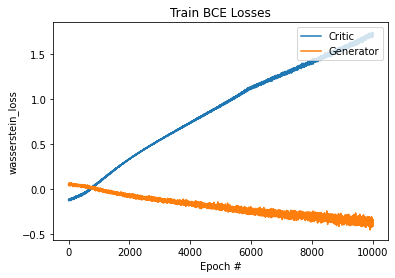

In [ ]:
# print(wgan.DLOS)
# print(wgan.GLOS)
plt.plot(wgan.GLOS)
plt.plot(wgan.DLOS)
plt.title('Train BCE Losses')
plt.ylabel('wasserstein_loss')
plt.xlabel('Epoch #')
plt.legend(['Critic','Generator'], loc='upper right')
plt.show()


In [ ]:
_, scaler = load_knn_data()
import pandas as pd
r, c = 6, 2000
noise = np.random.normal(0, 1, (c, 4))
gen_data = wgan.generator.predict(noise)
gen_data = scaler.inverse_transform(gen_data)

gen_data = pd.DataFrame(gen_data).to_csv('generateddata2.csv')

(2000, 4)
